1 Physical GPUs, 1 Logical GPUs
(39, 132, 30, 1)
2/2 [==============================] - 0s 993us/step


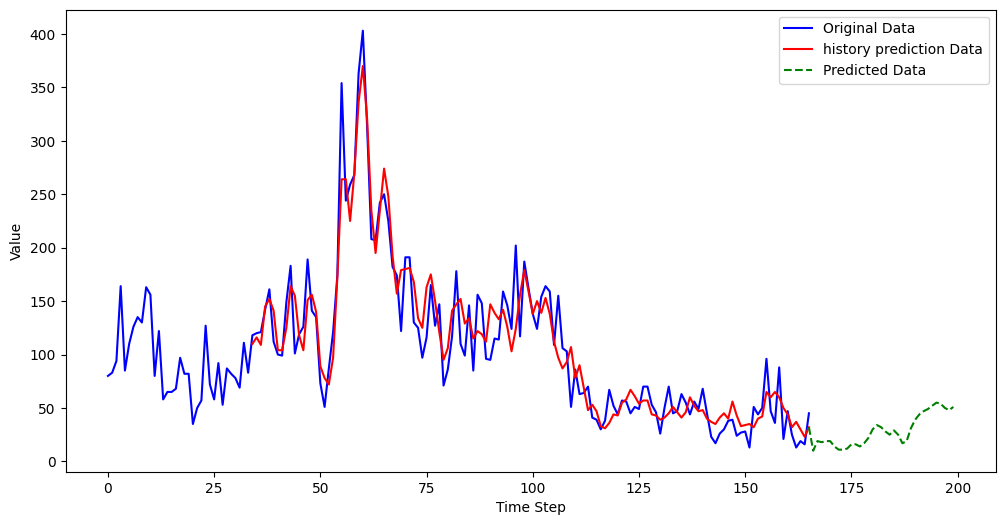

Final Choosen: None
(96, 132, 30, 1)
3/3 [==============================] - 0s 758us/step


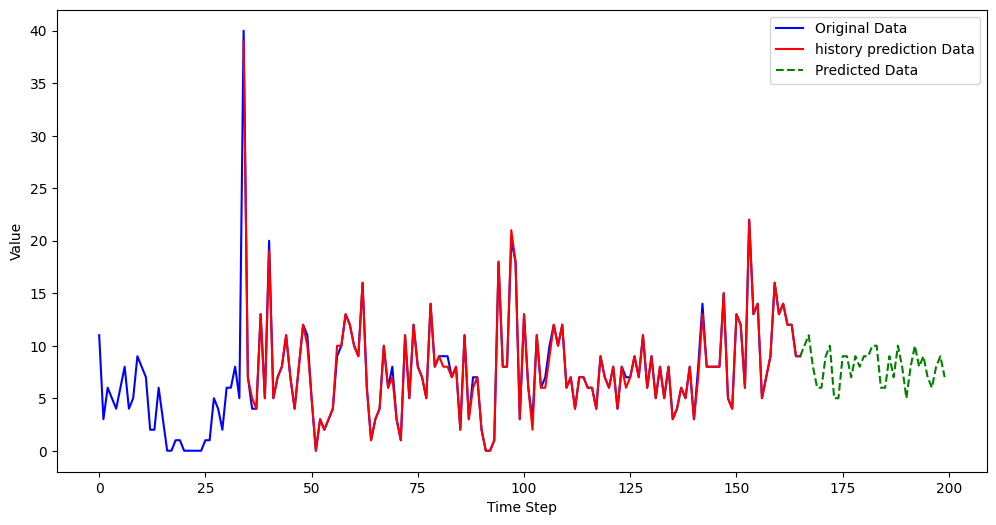

Final Choosen: None
(62, 132, 30, 1)
2/2 [==============================] - 0s 823us/step


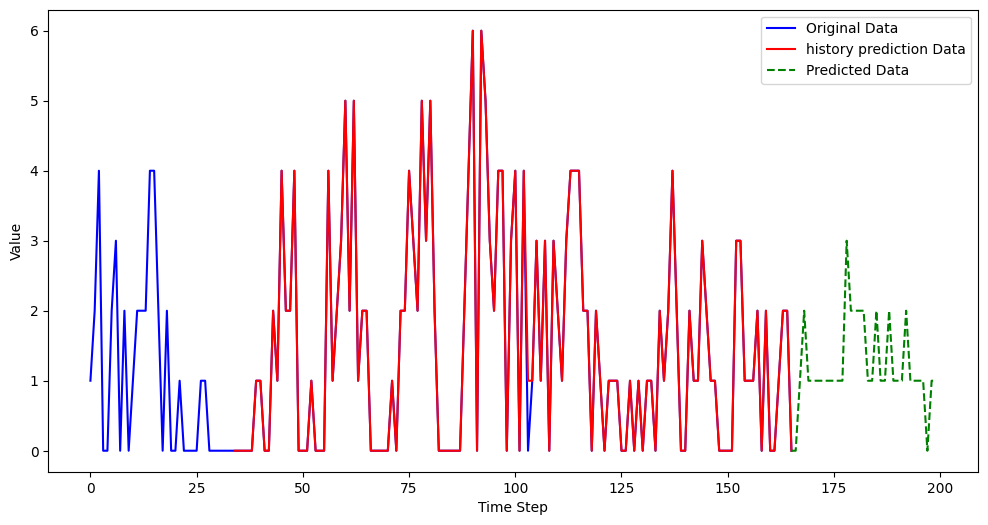

Final Choosen: None
(113, 132, 30, 1)
4/4 [==============================] - 0s 630us/step


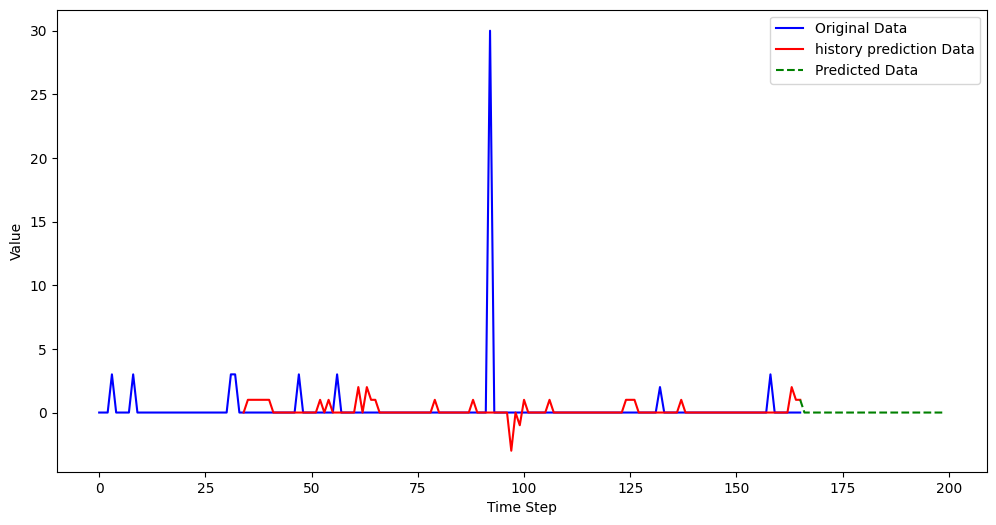

Final Choosen: None
(130, 132, 30, 1)
5/5 [==============================] - 0s 650us/step


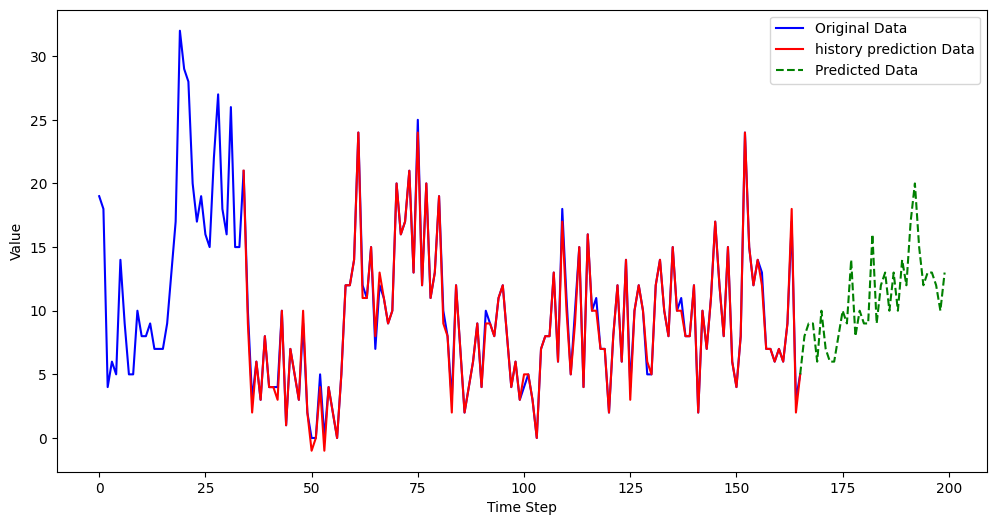

Final Choosen: None
(23, 132, 30, 1)
1/1 [==============================] - 0s 8ms/step


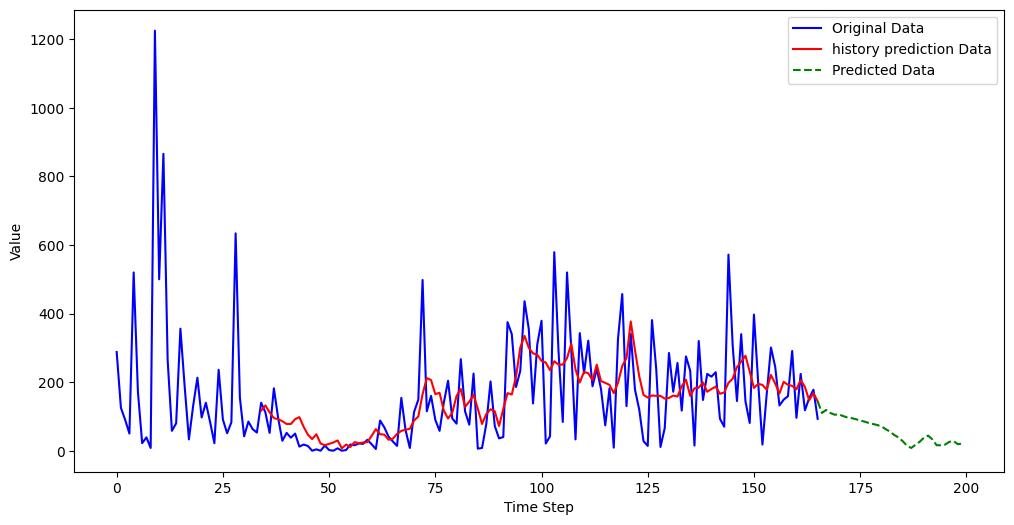

Final Choosen: None
(102, 132, 30, 1)
4/4 [==============================] - 0s 677us/step


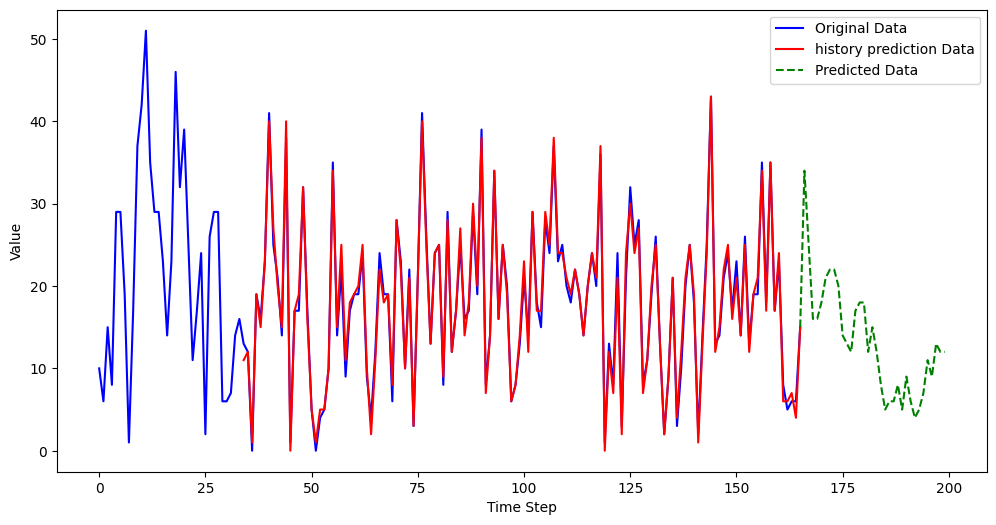

Final Choosen: None
(84, 132, 30, 1)
3/3 [==============================] - 0s 693us/step


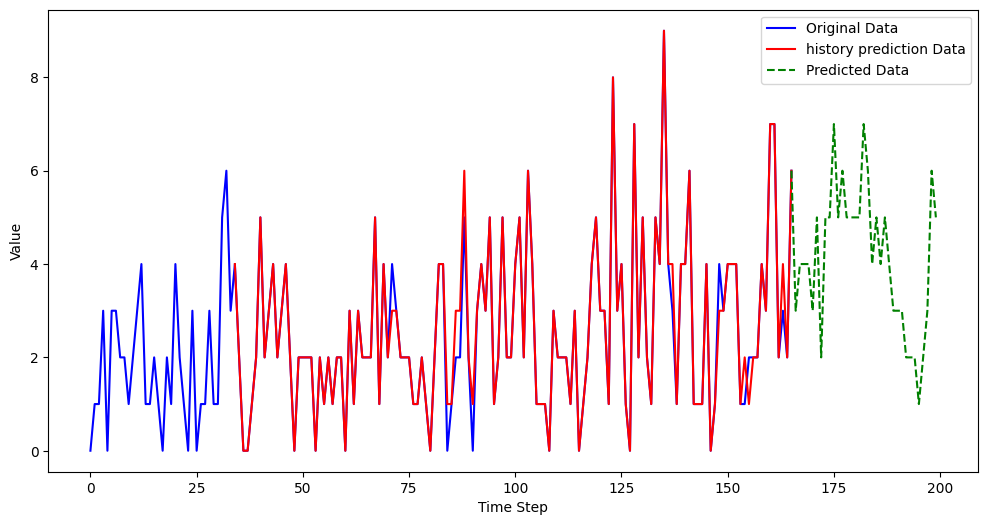

Final Choosen: None
(75, 132, 30, 1)
3/3 [==============================] - 0s 720us/step


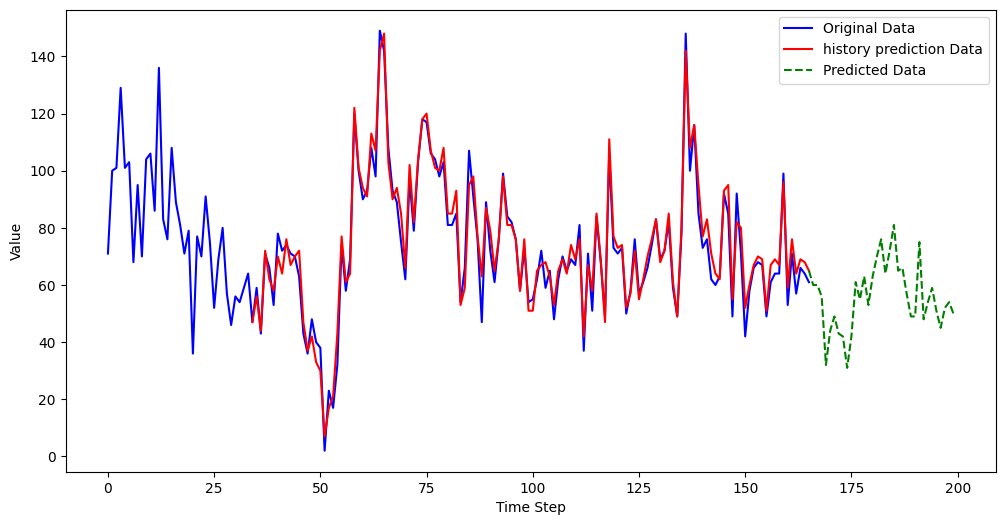

Final Choosen: None
(57, 132, 30, 1)
2/2 [==============================] - 0s 898us/step


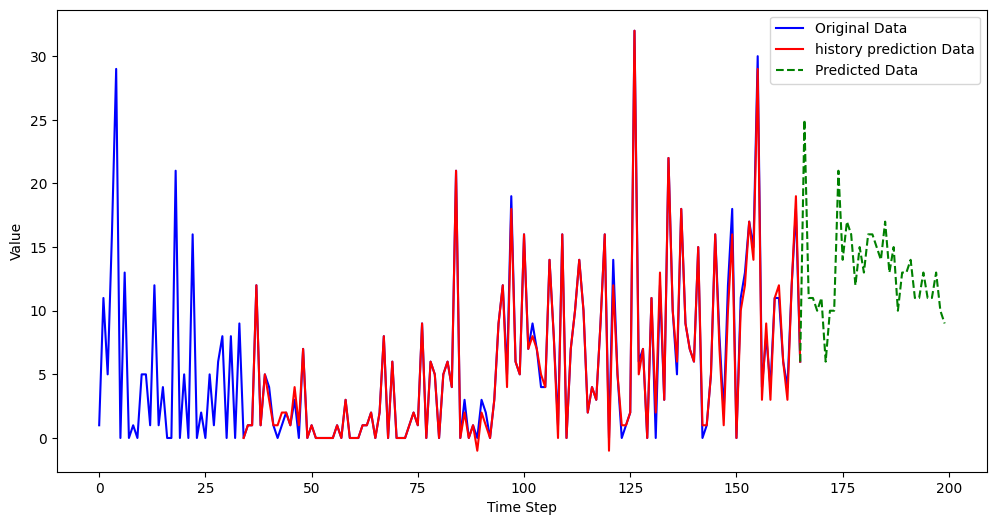

Final Choosen: None
(99, 132, 30, 1)
4/4 [==============================] - 0s 664us/step


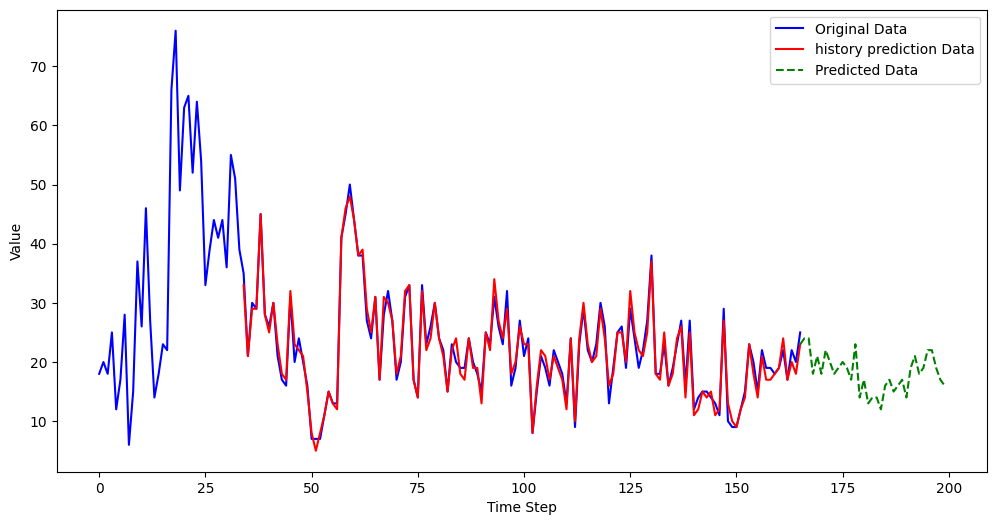

Final Choosen: None
(58, 132, 30, 1)
2/2 [==============================] - 0s 852us/step


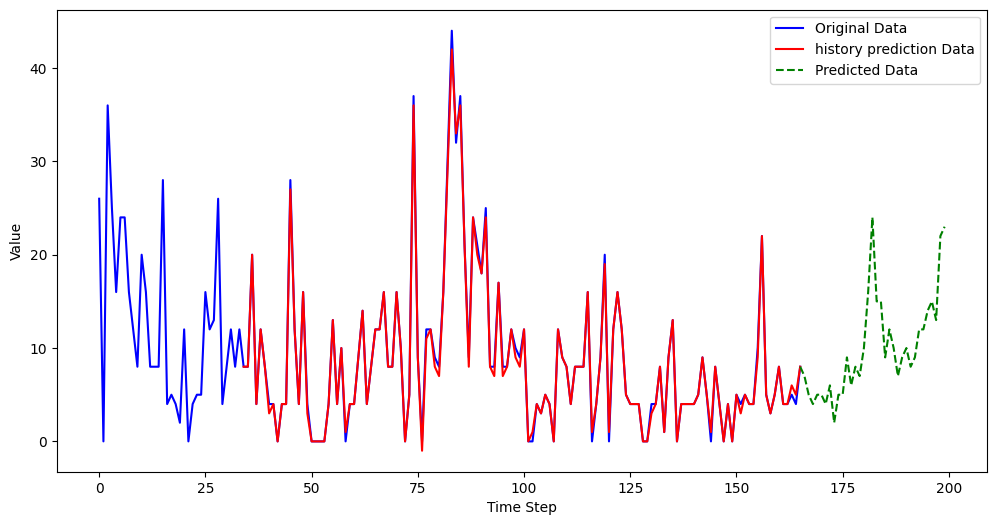

Final Choosen: None
(61, 132, 30, 1)
2/2 [==============================] - 0s 811us/step


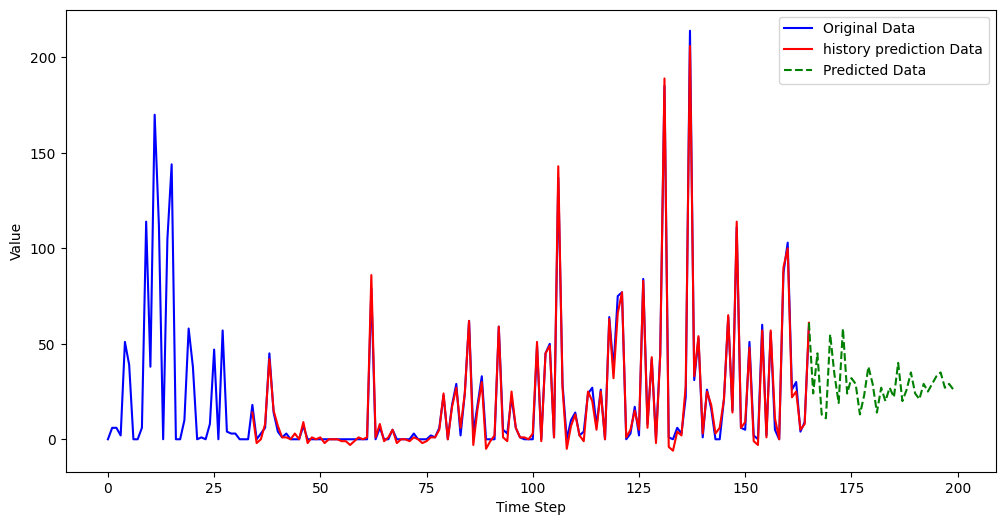

Final Choosen: None
(49, 132, 30, 1)
2/2 [==============================] - 0s 851us/step


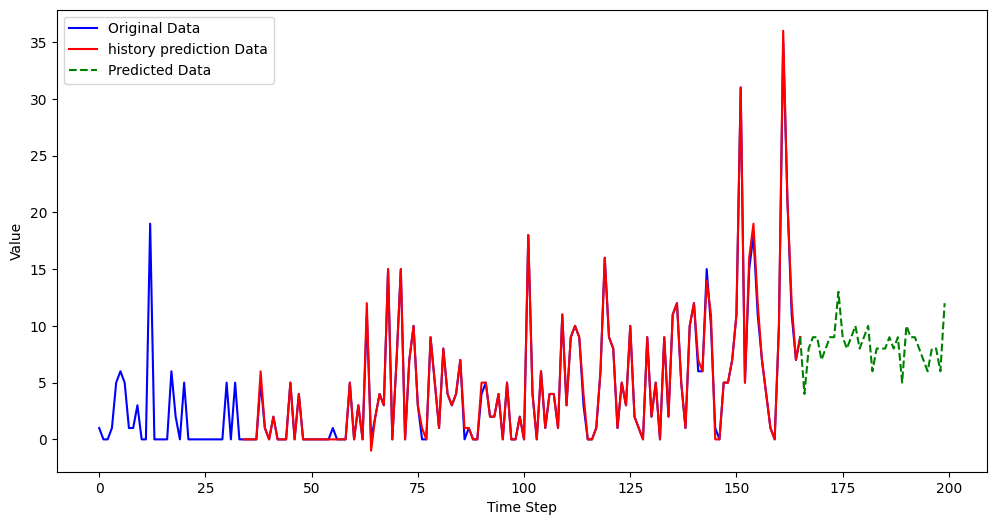

Final Choosen: None
(114, 132, 30, 1)
4/4 [==============================] - 0s 655us/step


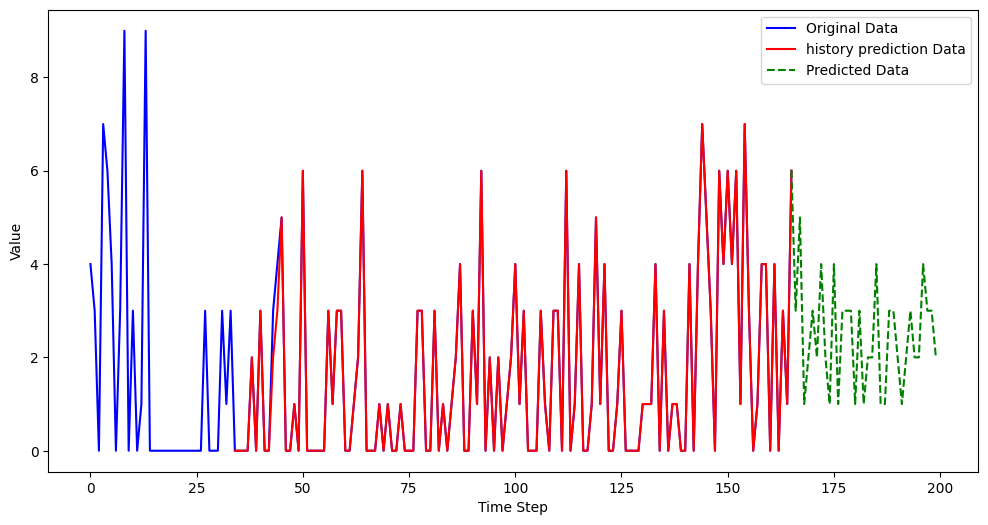

Final Choosen: None
(76, 132, 30, 1)
3/3 [==============================] - 0s 666us/step


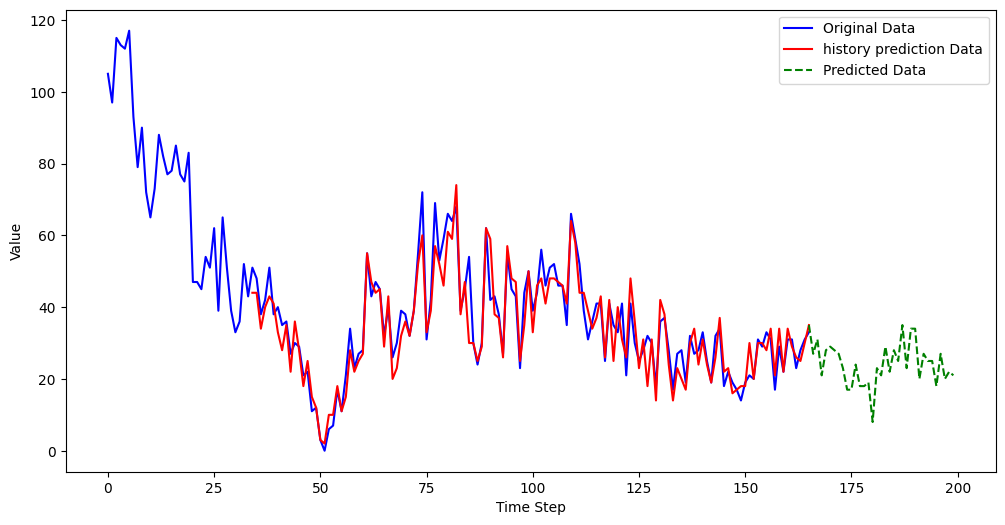

Final Choosen: None
(145, 132, 30, 1)
5/5 [==============================] - 0s 672us/step


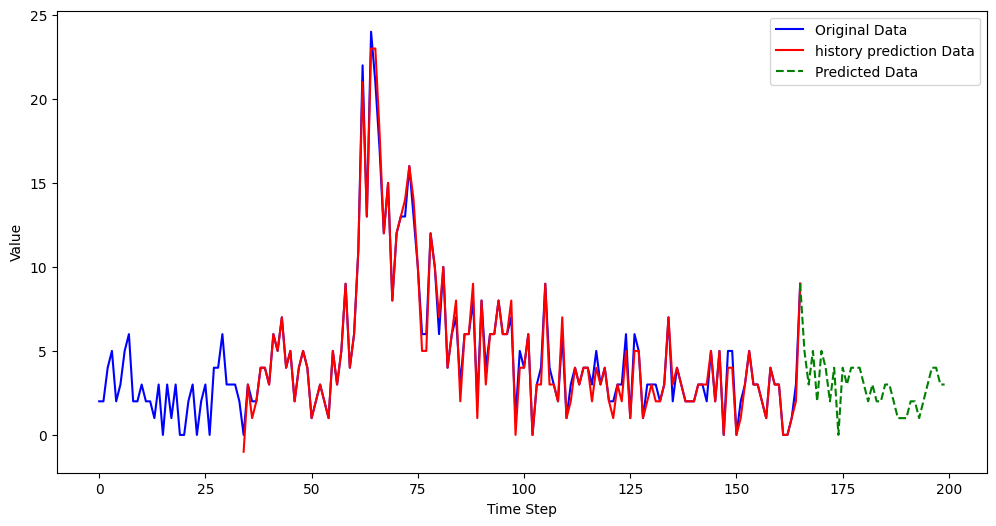

Final Choosen: None
(51, 132, 30, 1)
2/2 [==============================] - 0s 848us/step


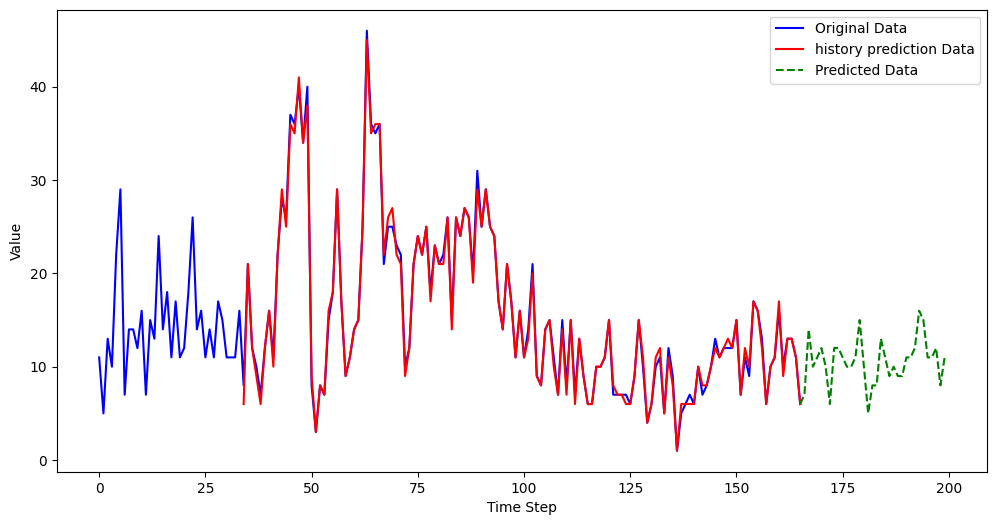

Final Choosen: None
(120, 132, 30, 1)
4/4 [==============================] - 0s 630us/step


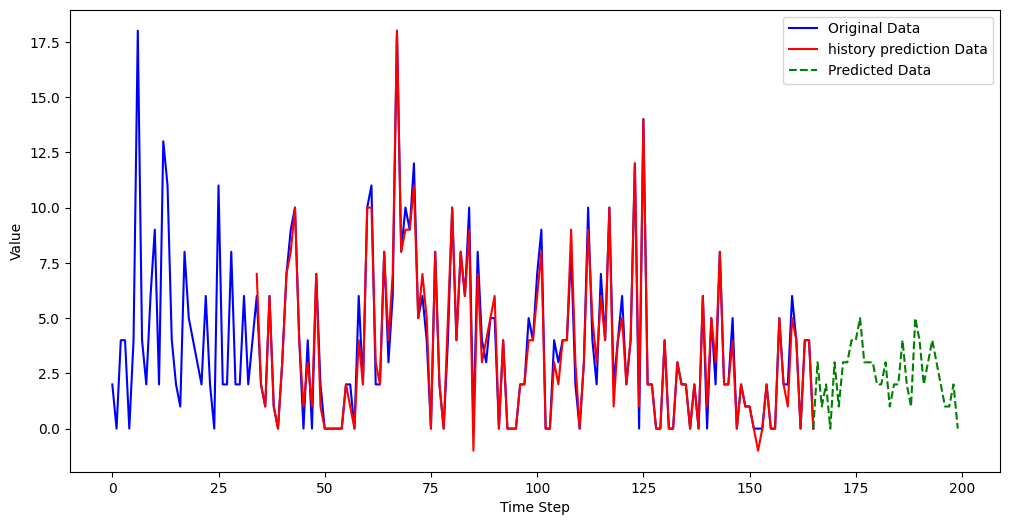

Final Choosen: None
(126, 132, 30, 1)
4/4 [==============================] - 0s 681us/step


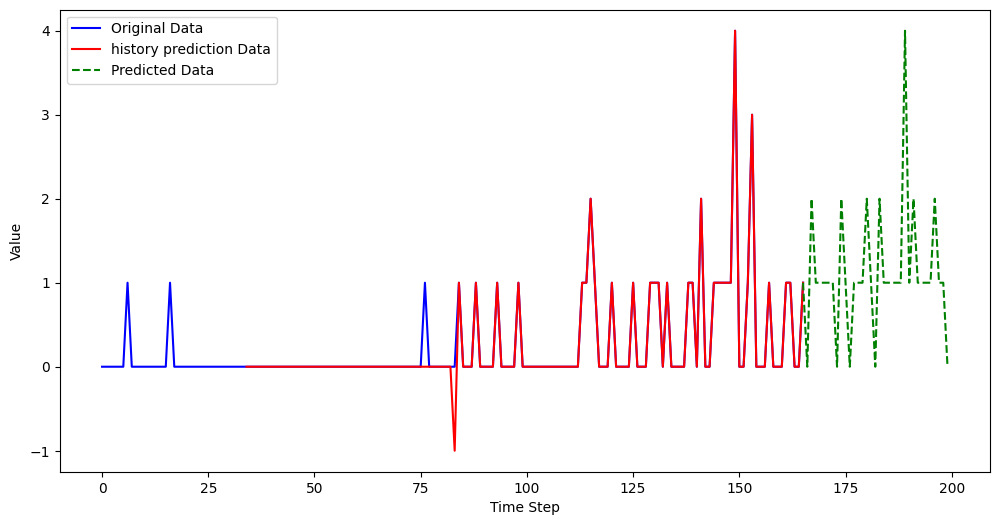

Final Choosen: None
(137, 132, 30, 1)
5/5 [==============================] - 0s 625us/step


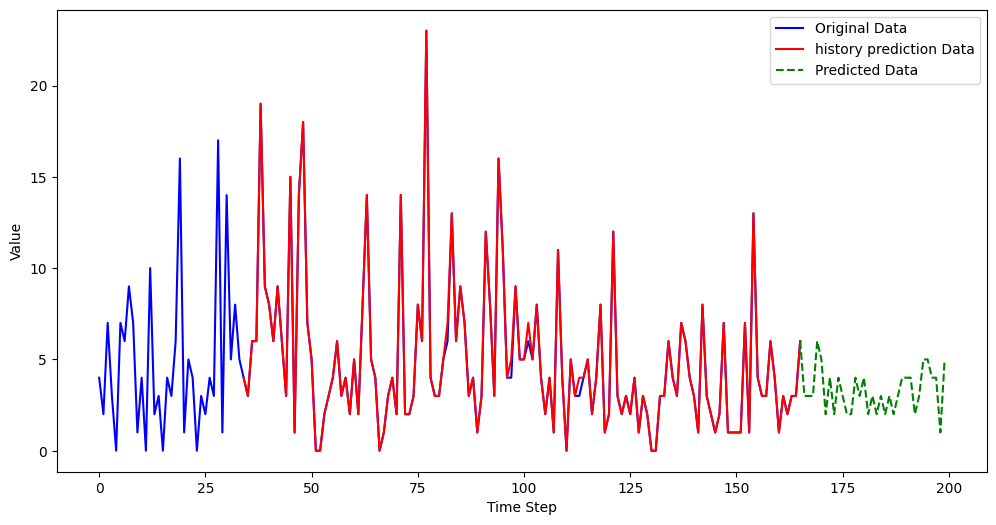

Final Choosen: None
(179, 132, 30, 1)
6/6 [==============================] - 0s 641us/step


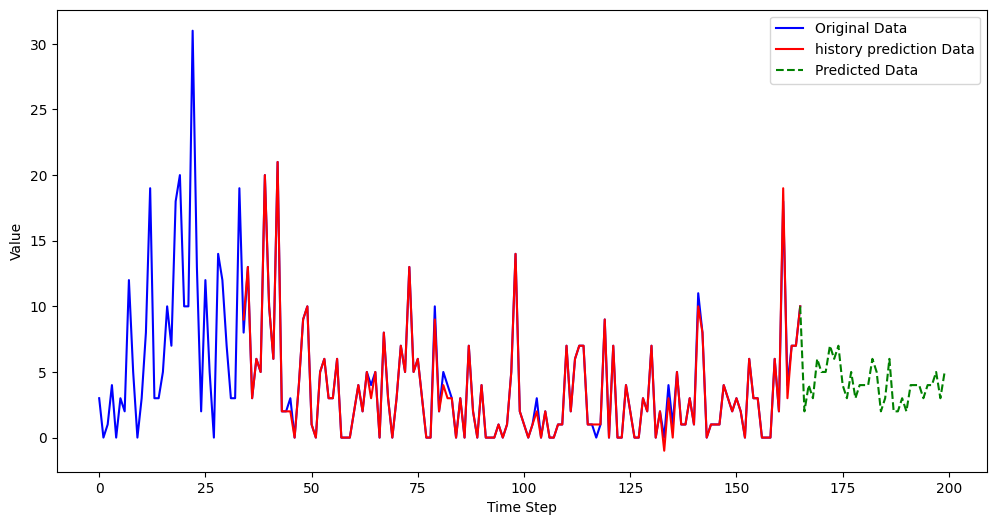

Final Choosen: None


In [4]:
from datetime import datetime
import time
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from keras.models import load_model

warnings.filterwarnings(action='ignore')

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:

        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.debugging.set_log_device_placement(True)

# 创建一个示例时间序列数据
# 这里的示例数据是随机生成的，请替换成你自己的时间序列数据
table = pd.read_csv("/workspace/数据处理编码withSTL_final.csv", encoding="utf-8", index_col=False)
table_save = table.copy()

# 定义滑动窗口的宽度与预测长度
window_size = 30
# 预测接下来的y_pre_len个时间点长度
next_predict = 30

y_pre_len = 5

for i in range(next_predict + y_pre_len - 1):
    table_save["extend_data" + str(i + 1)] = np.nan  # 初始化nan
table_save["acc_cal"] = np.nan  # 初始化nan
# table_save = pd.read_csv("table_save2/table_save_10_.csv", encoding="utf-8", index_col=0)

for fenlei_index in range(0, 22):
    fenlei = fenlei_index
    category_data = table[table['fenlei2'] == fenlei]
    start_index = 17
    category_t = category_data.columns[start_index:start_index + 166]
    datetime_list = [datetime.timestamp(datetime.strptime(ts, '%Y/%m/%d')) for ts in category_t]

    category_ylist = category_data.iloc[:, start_index:start_index + 166]

    time_series_data = np.array(category_ylist)

    #
    # # 创建一个示例时间序列数据，加入噪音信号
    # t = np.arange(0, 100, 1)  # 时间步
    # clean_data = np.sin(0.1 * t) * np.sin(0.8 * t)  # 示例函数
    #
    # # 创建包含10行数据的时间序列
    # num_rows = 10
    # data_rows = []
    #
    # # 为每一行数据创建不同的噪声信号
    # for i in range(num_rows):
    #     noise = np.random.normal(0, 0.1, 100)  # 每行数据的噪音信号
    #     row = clean_data + noise
    #     data_rows.append(row)
    #
    # time_series_data = np.array(data_rows)

    # 准备数据，将时间序列数据分割成输入（X）和输出（y）
    X = []
    y = []

    for i in range(time_series_data.shape[1] - window_size - y_pre_len + 1):
        X.append(time_series_data[:, i:i + window_size])
        y.append(time_series_data[:, i + window_size:i + window_size + y_pre_len])

    X = np.array(X).transpose(1, 0, 2).reshape(-1, 166 - window_size - y_pre_len + 1, window_size, 1)
    print(X.shape)
    y = np.array(y).transpose(1, 0, 2)

    loss_min = 999999999
    final_choosen = None

    # model_choose = model_choose_index
    # # # 创建一个简单的RNN模型
    model = load_model("/workspace/model_save1/"+"model_class_"+str(fenlei_index)+"_choosen" +".h5")
    # 预测历史时间步的值
    history_input = X
    history_input = history_input.reshape(-1, window_size, 1)
    history_predictions = []
    history_prediction = model.predict(history_input)
    history_predictions.append(history_prediction)

    history_predictions = np.array(history_predictions).reshape(-1, 166 - window_size - y_pre_len + 1, y_pre_len)[:,
                            :, -1]
    


    # 预测未来时间步的值
    # future_input = X[:, -1:]  # 使用最后一个窗口的数据作为输入
    future_input = time_series_data[:, -window_size:]  # 选取最后数据作为初始预测未来的输入
    future_input = future_input.reshape(-1, window_size, 1)
    future_predictions = []

    for _ in range(next_predict):
        future_prediction = model.predict(future_input)
        future_predictions.append(future_prediction)
        # 更新输入窗口，添加新的预测值，删除第一个时间步的数据
        # future_input = np.concatenate((future_input[:, y_pre_len:, :], future_prediction.reshape(-1,y_pre_len,1)), axis=1)
        future_input = np.concatenate(
            (future_input[:, 1:, :], np.round(future_prediction[:, 0:1]).reshape(-1, 1, 1)), axis=1)  # 步进1进行输入
        # print(future_input[1, -8:-1].reshape(1, -1))

    # 将预测结果转换为NumPy数组
    future_predictions = np.array(future_predictions).transpose(1, 0, 2).reshape(-1, next_predict, y_pre_len)

    # 创建一个长度为 next_predict+y_pre_len 的数组来存储输出
    final_output = np.zeros((future_predictions.shape[0], next_predict + y_pre_len - 1))
    weights = np.zeros(next_predict + y_pre_len - 1)

    # 对预测结果进行滑动窗口整合
    for i in range(future_predictions.shape[1]):
        final_output[:, i:i + 5] += future_predictions[:, i]
        weights[i:i + 5] += 1

    # 计算最终输出的平均值
    final_output = final_output / weights
    future_predictions = final_output.reshape(-1, next_predict + y_pre_len - 1, 1)

    future_predictions = np.round(future_predictions)
    history_predictions = np.round(history_predictions)

    for i in range(future_predictions.shape[1]):
        table_save["extend_data"+str(i+1)].loc[category_data.index] = future_predictions[:,i].flatten()

    accuracy_cal =  1-np.sum(np.abs(history_predictions - time_series_data[:,-history_predictions.shape[1]:]),axis = 1)/np.sum(time_series_data,axis =1)

    table_save["acc_cal"].loc[category_data.index] = accuracy_cal

    select_index = 1
    
    plot_series_data = time_series_data[select_index]
    plot_future_prediction = future_predictions[select_index]
    plot_history_prediction = history_predictions[select_index]
    # 绘制时间序列数据和预测值，使用不同颜色区分
    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(plot_series_data)), plot_series_data, label='Original Data', color='blue')
    plt.plot(np.arange(window_size + y_pre_len - 1, len(plot_series_data)), plot_history_prediction,
                label='history prediction Data', color='red')
    plt.plot(np.arange(len(plot_series_data) - 1, len(plot_series_data) + next_predict + y_pre_len - 1),
                np.insert(plot_future_prediction, 0, plot_history_prediction[-1:]),
                label='Predicted Data', color='green', ls="--")
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    # plt.savefig("save_pic/"+ model_choose+str(select_index)+str(fenlei_index)+".svg")
    plt.show()


    pass

    table_save.to_csv("/workspace/table_save22/table_save_" + str(fenlei_index) + "_.csv")
    print("Final Choosen:", final_choosen)
